Import Libraries

In [7]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Linear Regression models
from sklearn.linear_model import LinearRegression

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

Data preprocessing

Read data

In [8]:
df = pd.read_csv('Xiaomi_clean.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.6,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.0,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.5,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.4,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.6,21.799999,19.520000,21.450001,21.450001,364065075


Reset index

In [9]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the Close column as dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)
df_Close.head()


,Close
0,16.799999
1,19.000000
2,19.000000
3,19.260000
4,21.450001


Data normalization

In [10]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

Data splitting

In [11]:
# Split data into training, validation, and test sets (6:2:2)
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

Model training and testing

Training process

In [12]:
# Prepare training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

# Train Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R-squared:", model.score(x_train, y_train))

Intercept: 0.09316269635402086
Coefficients: [0.00010576]
R-squared: 0.06693429595566036


Testing process

In [13]:
# Validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(x_val)

# Evaluate
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val_inv, y_pred_val_inv)

print(f"MAPE (Validation): {val_mape}")
print(f"RMSE (Validation): {val_rmse}")
print(f"MSLE (Validation): {val_msle}")


MAPE (Validation): 0.5907073777125886
RMSE (Validation): 7.39396376983738
MSLE (Validation): 0.19765813989917436


In [14]:
# Test data
x_test = np.array(range(train_size + val_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred_test = model.predict(x_test)

# Evaluate
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_test_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test_inv, y_pred_test_inv)

print(f"MAPE (Test): {test_mape}")
print(f"RMSE (Test): {test_rmse}")
print(f"MSLE (Test): {test_msle}")


MAPE (Test): 0.39502641601488775
RMSE (Test): 21.76137553484235
MSLE (Test): 0.3669478720532528


Predicting the next 30 days

In [15]:
# Create index for next 30 days
last_index = df_Close.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

Preparing the prediction data

Prediction process

In [16]:
# Predict next 30 days
y_next_30_days = model.predict(x_next_30_days)
y_next_30_days_inv = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))

print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_inv.flatten())


Predicted closing prices for the next 30 days:
[23.03688964 23.04236801 23.04784638 23.05332474 23.05880311 23.06428148
 23.06975985 23.07523821 23.08071658 23.08619495 23.09167332 23.09715168
 23.10263005 23.10810842 23.11358679 23.11906515 23.12454352 23.13002189
 23.13550026 23.14097862 23.14645699 23.15193536 23.15741373 23.16289209
 23.16837046 23.17384883 23.1793272  23.18480556 23.19028393 23.1957623 ]


Preparing the forecast date index

In [17]:
# Generate future date index
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

Visualization

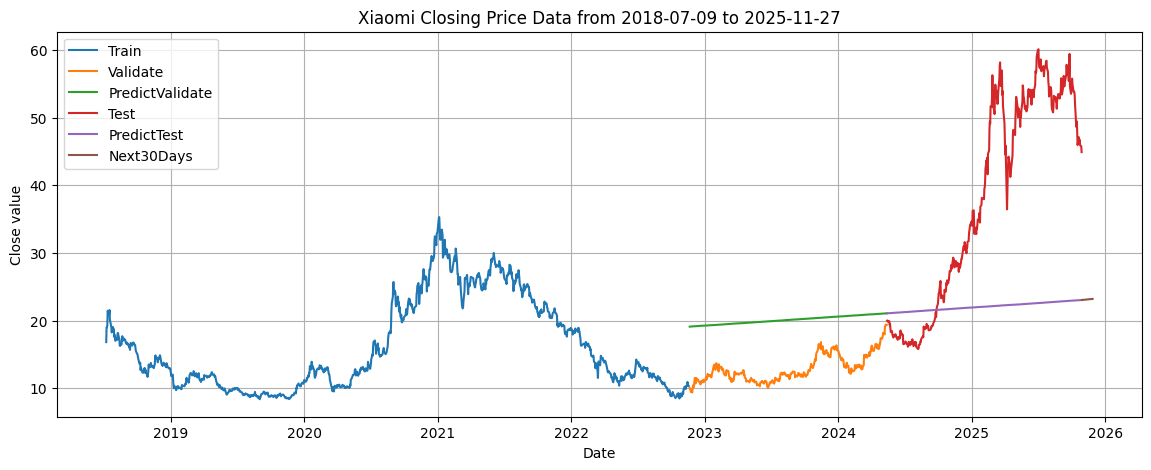

In [18]:
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(df.index[train_size:train_size + val_size], y_val_inv)
plt.plot(df.index[train_size:train_size + val_size], y_pred_val_inv)
plt.plot(df.index[train_size + val_size:], y_test_inv)
plt.plot(df.index[train_size + val_size:], y_pred_test_inv)
plt.plot(index_next_30_days, y_next_30_days_inv)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Days'])
plt.grid()
plt.title(f"Xiaomi Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('LR_622_Xiaomi.png')
plt.show()
